In [1]:
!pip install dipy
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.9 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive
mount_path = '/content/drive'
drive_path = mount_path+"/MyDrive/dti-transformer/code/model"
results_path = drive_path+"/results/MD"
drive.mount(mount_path)
os.chdir(drive_path)

Mounted at /content/drive


In [3]:
# Daniel Bandala @ nov-2022
# dti-model training script
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
# diffussion image processing
from dipy.io.image import load_nifti
# import torch libraries
import torch   
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR   
# import dataset auxiliar libraries
from data_loader import *
from tqdm.notebook import tqdm
# import model
from dti_model import DiffusionTensorModel

In [4]:
# set plot parameters
plt.rcParams.update({'font.size': 20})

In [5]:
# folders dataset
main_dir = '/content/drive/MyDrive/dti-transformer/dti_data/HCP'

In [6]:
# read difussion data
data, affine = load_nifti(main_dir+'/case_02/input/DWI_opt.nii.gz')
data.shape

(140, 140, 96, 15)

In [7]:
# read difussion data
output, _ = load_nifti(main_dir+'/case_02/output/DTI_MD.nii.gz')
output.shape

(140, 140, 96)

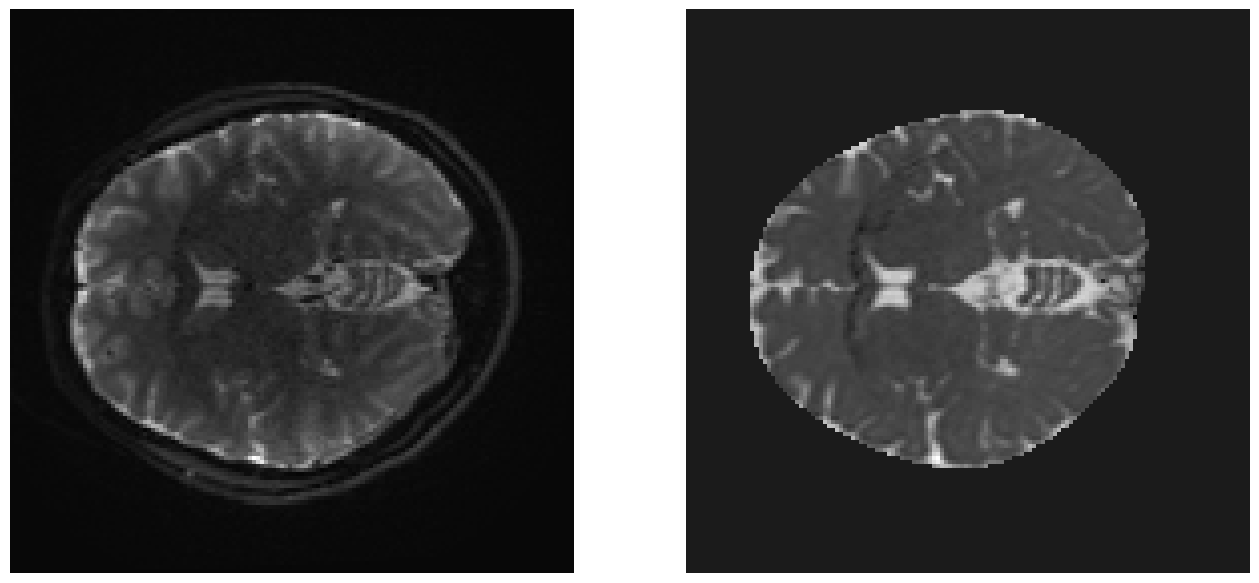

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, 48, 0], cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(output[:, :, 48], cmap='gray', origin='lower')

In [9]:
# input channels
signals = 15
# define training parameters
batches = 10
epochs = 180
test_size = 0.1
start_epoch = 0
# optimizer parameters
lr = 2e-4
weight_decay = 1e-4
gamma = 0.9 #for learning rate scheduler
step_size = 1
seed = 24
# select available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# folders dataset
main_dir = ['/content/drive/MyDrive/dti-transformer/dti_data/HCP',
            '/content/drive/MyDrive/dti-transformer/dti_data/ADNI']

In [11]:
# load dataset
maps = ["MD"] #"FA","MD","MO","L1","L2","L3"
train_list, valid_list, train_loader, valid_loader = get_dataset(main_dir, test_size, batches, maps=maps, signals=signals, dti_folder='dti')

Dataset size: 59
Train Data: 53
Validation Data: 6


In [12]:
# load model
model = DiffusionTensorModel(
    in_chans=signals,
    out_chans=len(maps),
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=2,
    depth_prob=0.2,
    tanh_output=True
)
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [13]:
device
# copy model to gpu
_ = model.to(device)

In [14]:
# enable training graphics widget
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [15]:
# model weights path
continue_training = True
model_path = results_path+"/dti_md.weights"
ch_path = results_path+"/opt.pt.tar"

In [16]:
# load model and parameters to keep training
if continue_training:
    checkpoint = torch.load(ch_path)
    start_epoch = int(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#model = torch.load(model_path, map_location=torch.device(device))

In [17]:
# set model on training mode
_ = model.train()
# get trainable parameters
print("Trainable parameters: ", get_params(model))

Trainable parameters:  40424703


In [18]:
#start training
ep_loss = [] 
# error variables
prev_error = float("inf")
#seed_everything(seed)
for epoch in range(start_epoch, epochs):
    epoch_loss = 0.
    for batch_data, batch_label in tqdm(train_loader):
        batch_range = list(range(batch_data.shape[0]))
        shuffle(batch_range)
        for i in batch_range:
            slice_data = batch_data[i].to(device)
            slice_label = batch_label[i].to(device)
            samples_t = slice_data.shape[0]
            s_counter = 0
            slice_range = list(range(samples_t))
            shuffle(slice_range)
            for s in slice_range:
                s_counter += 1
                data = slice_data[s]
                label = slice_label[s]

                # forward - evaluate model
                output = model(data)
                loss = criterion(output, label)
                # backward propagation
                loss.backward()

                # loss average
                epoch_loss += loss.item()

                #if s_counter%48==0:
            # optimize model - update network weights
            optimizer.step()
            # zero the parameter gradient
            optimizer.zero_grad()

    # calculate loss on validation set
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data, batch_label in valid_loader:
            for i in range(batch_data.shape[0]):
                slice_data = batch_data[i].to(device)
                slice_label = batch_label[i].to(device)
                samples_v = slice_data.shape[0]
                for s in range(samples_v):
                    data = slice_data[s]
                    label = slice_label[s]
                    # evaluate model on validation case
                    val_output = model(data)
                    val_loss = criterion(val_output, label)
                    # validation loss
                    epoch_val_loss += val_loss.item()

    # append to epoch array
    epoch_loss = epoch_loss/(len(train_list)*samples_t)
    epoch_val_loss = epoch_val_loss/(len(valid_list)*samples_v)
    ep_loss.append([epoch_loss,epoch_val_loss])
    # adjust learning rate in case the error did not decrease
    if prev_error<epoch_loss:
        scheduler.step()
    # assign epoch loss to next comparisson
    prev_error = epoch_loss
    # save loss graph status
    fig=plt.figure(figsize=(16,8))
    plt.ion()
    plt.plot(range(1, len(ep_loss) + 1), ep_loss, linewidth=4)
    plt.title("Average loss function for each epoch")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.legend(['Training loss', 'Validation loss'],loc="upper right")
    #plt.ylim([0, 2])
    plt.grid()
    try:
        plt.savefig(results_path+"/avg_loss.png")
    except Exception as e:
        print("Error saving loss graph")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    finally:
        plt.close(fig)
    # save error list
    try:
        pd.DataFrame(ep_loss).to_csv(results_path+"/training_loss.csv",index=False, header=False)
    except Exception as e:
        print("Error saving loss data")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    finally:
        plt.close(fig)
    # save model weights and training parameters
    try:
        torch.save({'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict()
                    }, ch_path)
    except Exception as e:
        print("Error saving model")
        drive.mount(mount_path, force_remount=True)
        os.chdir(drive_path)
    # print epoch metrics
    print(
        f"Epoch: {epoch+1}  -  train loss: {epoch_loss:.8f}  -  valid loss: {epoch_val_loss:.8f} \n"
    )
# return model to cpu
_ = model.to("cpu")
# save final model
torch.save(model.state_dict(), model_path)
# complete
print("\nTraining finished")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 33  -  train loss: 0.00216474  -  valid loss: 0.00190590 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 34  -  train loss: 0.00202843  -  valid loss: 0.00175336 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 35  -  train loss: 0.00197533  -  valid loss: 0.00174405 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 36  -  train loss: 0.00203848  -  valid loss: 0.00186041 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 37  -  train loss: 0.00202973  -  valid loss: 0.00172455 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 38  -  train loss: 0.00189987  -  valid loss: 0.00172758 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 39  -  train loss: 0.00186945  -  valid loss: 0.00181603 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 40  -  train loss: 0.00183820  -  valid loss: 0.00181513 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 41  -  train loss: 0.00189044  -  valid loss: 0.00168746 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 42  -  train loss: 0.00188286  -  valid loss: 0.00162610 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 43  -  train loss: 0.00192451  -  valid loss: 0.00172277 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 44  -  train loss: 0.00191849  -  valid loss: 0.00167390 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 45  -  train loss: 0.00180613  -  valid loss: 0.00159437 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 46  -  train loss: 0.00181352  -  valid loss: 0.00162909 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 47  -  train loss: 0.00177250  -  valid loss: 0.00155332 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 48  -  train loss: 0.00174147  -  valid loss: 0.00153988 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 49  -  train loss: 0.00171241  -  valid loss: 0.00153721 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 50  -  train loss: 0.00171790  -  valid loss: 0.00152983 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 51  -  train loss: 0.00169037  -  valid loss: 0.00161311 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 52  -  train loss: 0.00173685  -  valid loss: 0.00159534 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 53  -  train loss: 0.00168243  -  valid loss: 0.00170526 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 54  -  train loss: 0.00166421  -  valid loss: 0.00153432 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 55  -  train loss: 0.00166619  -  valid loss: 0.00145653 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 56  -  train loss: 0.00163592  -  valid loss: 0.00154794 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 57  -  train loss: 0.00169393  -  valid loss: 0.00145651 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 58  -  train loss: 0.00164651  -  valid loss: 0.00151713 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 59  -  train loss: 0.00161501  -  valid loss: 0.00141202 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 60  -  train loss: 0.00161115  -  valid loss: 0.00141793 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 61  -  train loss: 0.00160237  -  valid loss: 0.00144821 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 62  -  train loss: 0.00169022  -  valid loss: 0.00148955 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 63  -  train loss: 0.00164484  -  valid loss: 0.00156852 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 64  -  train loss: 0.00160609  -  valid loss: 0.00140927 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 65  -  train loss: 0.00158792  -  valid loss: 0.00137641 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 66  -  train loss: 0.00156304  -  valid loss: 0.00137707 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 67  -  train loss: 0.00157184  -  valid loss: 0.00153545 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 68  -  train loss: 0.00158969  -  valid loss: 0.00140004 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 69  -  train loss: 0.00161611  -  valid loss: 0.00150992 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 70  -  train loss: 0.00155039  -  valid loss: 0.00133840 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 71  -  train loss: 0.00154070  -  valid loss: 0.00142043 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 72  -  train loss: 0.00153817  -  valid loss: 0.00133101 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 73  -  train loss: 0.00156099  -  valid loss: 0.00141752 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 74  -  train loss: 0.00152537  -  valid loss: 0.00134059 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 75  -  train loss: 0.00150394  -  valid loss: 0.00141617 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 76  -  train loss: 0.00151974  -  valid loss: 0.00129885 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 77  -  train loss: 0.00150472  -  valid loss: 0.00131524 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 78  -  train loss: 0.00148885  -  valid loss: 0.00144819 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 79  -  train loss: 0.00148203  -  valid loss: 0.00132245 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 80  -  train loss: 0.00151762  -  valid loss: 0.00150102 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 81  -  train loss: 0.00152552  -  valid loss: 0.00131279 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 82  -  train loss: 0.00147512  -  valid loss: 0.00137394 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 83  -  train loss: 0.00145723  -  valid loss: 0.00128508 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 84  -  train loss: 0.00144065  -  valid loss: 0.00129015 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 85  -  train loss: 0.00146298  -  valid loss: 0.00135474 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 86  -  train loss: 0.00146312  -  valid loss: 0.00128754 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 87  -  train loss: 0.00143791  -  valid loss: 0.00135566 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 88  -  train loss: 0.00143234  -  valid loss: 0.00128885 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 89  -  train loss: 0.00146119  -  valid loss: 0.00131540 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 90  -  train loss: 0.00142803  -  valid loss: 0.00129061 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 91  -  train loss: 0.00142992  -  valid loss: 0.00140110 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 92  -  train loss: 0.00144537  -  valid loss: 0.00124312 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 93  -  train loss: 0.00142737  -  valid loss: 0.00126332 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 94  -  train loss: 0.00140223  -  valid loss: 0.00125780 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 95  -  train loss: 0.00140349  -  valid loss: 0.00126798 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 96  -  train loss: 0.00139068  -  valid loss: 0.00124034 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 97  -  train loss: 0.00139779  -  valid loss: 0.00123585 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 98  -  train loss: 0.00139534  -  valid loss: 0.00129316 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 99  -  train loss: 0.00140300  -  valid loss: 0.00126187 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 100  -  train loss: 0.00138805  -  valid loss: 0.00134668 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 101  -  train loss: 0.00139496  -  valid loss: 0.00126444 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 102  -  train loss: 0.00138744  -  valid loss: 0.00123565 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 103  -  train loss: 0.00137660  -  valid loss: 0.00122990 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 104  -  train loss: 0.00138124  -  valid loss: 0.00123437 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 105  -  train loss: 0.00138187  -  valid loss: 0.00130213 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 106  -  train loss: 0.00136679  -  valid loss: 0.00126151 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 107  -  train loss: 0.00137737  -  valid loss: 0.00122286 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 108  -  train loss: 0.00136109  -  valid loss: 0.00123826 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 109  -  train loss: 0.00136721  -  valid loss: 0.00120580 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 110  -  train loss: 0.00137279  -  valid loss: 0.00121173 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 111  -  train loss: 0.00135712  -  valid loss: 0.00121817 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 112  -  train loss: 0.00135634  -  valid loss: 0.00123703 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 113  -  train loss: 0.00134959  -  valid loss: 0.00122448 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 114  -  train loss: 0.00135686  -  valid loss: 0.00124641 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 115  -  train loss: 0.00135756  -  valid loss: 0.00122409 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 116  -  train loss: 0.00135498  -  valid loss: 0.00122661 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 117  -  train loss: 0.00134681  -  valid loss: 0.00121841 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 118  -  train loss: 0.00134723  -  valid loss: 0.00124432 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 119  -  train loss: 0.00134205  -  valid loss: 0.00119968 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 120  -  train loss: 0.00133991  -  valid loss: 0.00120048 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 121  -  train loss: 0.00135241  -  valid loss: 0.00120163 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 122  -  train loss: 0.00134144  -  valid loss: 0.00120050 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 123  -  train loss: 0.00133940  -  valid loss: 0.00123517 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 124  -  train loss: 0.00134566  -  valid loss: 0.00119846 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 125  -  train loss: 0.00133157  -  valid loss: 0.00121299 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 126  -  train loss: 0.00133231  -  valid loss: 0.00120741 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 127  -  train loss: 0.00133103  -  valid loss: 0.00124984 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 128  -  train loss: 0.00133537  -  valid loss: 0.00119922 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 129  -  train loss: 0.00132783  -  valid loss: 0.00122666 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 130  -  train loss: 0.00133377  -  valid loss: 0.00120855 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 131  -  train loss: 0.00133324  -  valid loss: 0.00120613 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 132  -  train loss: 0.00132733  -  valid loss: 0.00122268 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 133  -  train loss: 0.00132352  -  valid loss: 0.00121300 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 134  -  train loss: 0.00132584  -  valid loss: 0.00119476 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 135  -  train loss: 0.00132720  -  valid loss: 0.00119361 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 136  -  train loss: 0.00132406  -  valid loss: 0.00121309 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 137  -  train loss: 0.00132161  -  valid loss: 0.00120126 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 138  -  train loss: 0.00131799  -  valid loss: 0.00121554 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 139  -  train loss: 0.00131757  -  valid loss: 0.00120316 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 140  -  train loss: 0.00132202  -  valid loss: 0.00121944 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 141  -  train loss: 0.00132421  -  valid loss: 0.00120994 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 142  -  train loss: 0.00132059  -  valid loss: 0.00119947 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 143  -  train loss: 0.00131867  -  valid loss: 0.00119850 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 144  -  train loss: 0.00131666  -  valid loss: 0.00118889 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 145  -  train loss: 0.00131688  -  valid loss: 0.00120089 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 146  -  train loss: 0.00131424  -  valid loss: 0.00119843 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 147  -  train loss: 0.00131546  -  valid loss: 0.00122020 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 148  -  train loss: 0.00131363  -  valid loss: 0.00119400 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 149  -  train loss: 0.00130934  -  valid loss: 0.00120587 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 150  -  train loss: 0.00131319  -  valid loss: 0.00119806 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 151  -  train loss: 0.00131772  -  valid loss: 0.00119779 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 152  -  train loss: 0.00130808  -  valid loss: 0.00120924 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 153  -  train loss: 0.00131142  -  valid loss: 0.00118738 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 154  -  train loss: 0.00130682  -  valid loss: 0.00119557 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 155  -  train loss: 0.00130851  -  valid loss: 0.00118992 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 156  -  train loss: 0.00130777  -  valid loss: 0.00119939 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 157  -  train loss: 0.00130750  -  valid loss: 0.00120149 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 158  -  train loss: 0.00130758  -  valid loss: 0.00119367 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 159  -  train loss: 0.00130530  -  valid loss: 0.00119085 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 160  -  train loss: 0.00130687  -  valid loss: 0.00119172 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 161  -  train loss: 0.00130898  -  valid loss: 0.00119647 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 162  -  train loss: 0.00130260  -  valid loss: 0.00119930 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 163  -  train loss: 0.00130540  -  valid loss: 0.00119381 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 164  -  train loss: 0.00130380  -  valid loss: 0.00119226 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 165  -  train loss: 0.00130929  -  valid loss: 0.00119093 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 166  -  train loss: 0.00130409  -  valid loss: 0.00119435 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 167  -  train loss: 0.00130254  -  valid loss: 0.00119713 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 168  -  train loss: 0.00130303  -  valid loss: 0.00119578 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 169  -  train loss: 0.00130829  -  valid loss: 0.00119900 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 170  -  train loss: 0.00130504  -  valid loss: 0.00119489 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 171  -  train loss: 0.00130659  -  valid loss: 0.00119325 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 172  -  train loss: 0.00130583  -  valid loss: 0.00119424 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 173  -  train loss: 0.00130289  -  valid loss: 0.00119560 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 174  -  train loss: 0.00130019  -  valid loss: 0.00119565 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 175  -  train loss: 0.00130274  -  valid loss: 0.00118933 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 176  -  train loss: 0.00130378  -  valid loss: 0.00119790 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 177  -  train loss: 0.00129898  -  valid loss: 0.00119168 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 178  -  train loss: 0.00130540  -  valid loss: 0.00119316 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 179  -  train loss: 0.00130247  -  valid loss: 0.00119470 



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 180  -  train loss: 0.00130351  -  valid loss: 0.00119422 


Training finished


In [19]:
# evaluate model
data, label = data_preprocessing(valid_list[2], maps=maps, signals=signals, dti_folder='dti')
data_val, label_val = data[48], label[48]

In [20]:
_ = model.to("cpu")
model.eval()
with torch.no_grad():
    output = model(data_val)

In [21]:
print("Data: ",data.shape)
print("Label: ",label.shape)
print("Data to evaluate: ",data_val.shape)
print("Label to evaluate: ",label_val.shape)
print("Output: ",output.shape)

Data:  torch.Size([96, 15, 140, 140])
Label:  torch.Size([96, 140, 140])
Data to evaluate:  torch.Size([15, 140, 140])
Label to evaluate:  torch.Size([140, 140])
Output:  torch.Size([140, 140])


In [22]:
# detach data
data_eval_np = data_val.detach().numpy()
label_eval_np = label_val.detach().numpy()
output_eval_np = output.detach().numpy()

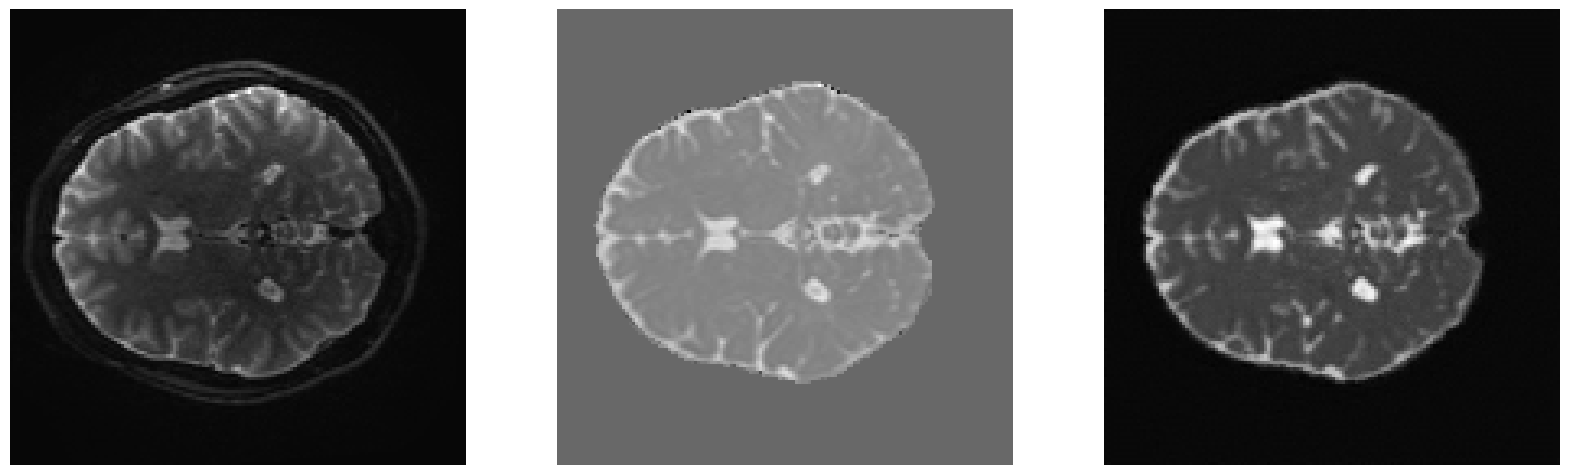

In [23]:
# print visual evaluation
plt.figure(figsize=(20,12))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data_eval_np[0], cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(label_eval_np, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(output_eval_np, cmap='gray', origin='lower')
plt.savefig(results_path+"/md_result.png")

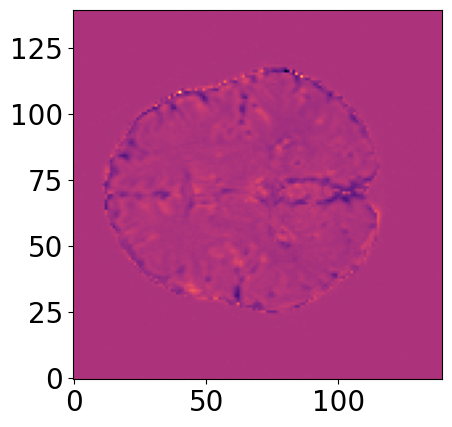

In [24]:
res = label_eval_np-output_eval_np
plt.imshow(res, cmap='magma_r', origin='lower')